In [1]:
import numpy as np
from collections import defaultdict

import gzip

import csv

from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc

import heapq

import matplotlib.pyplot as plt


In [2]:
drug_mapping = defaultdict(list)
all_drugs = list()

with open('/home/rvanguri/deeplink/data/ingredientList.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        #print line
        mapped = line[7]
        concept_id = line[0]
        drug_mapping[mapped] = concept_id
        all_drugs.append(line[0])

In [3]:
all_outcomes = list()
with open('/home/rvanguri/deeplink/data/reactionList.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        all_outcomes.append(line[0])

In [4]:
all_pairoutcomes = list()
with open('/home/rvanguri/deeplink/data/pairReactions.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        all_pairoutcomes.append(line[0])

In [5]:
all_drugpairs = list()
with open('/home/rvanguri/deeplink/data/drugpairList.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        all_drugpairs.append(line)

In [6]:
druglist = list()
chem_features = np.zeros((1,64))

with open('/home/rvanguri/drugs_simple_chem_features_formatted.txt') as f:
    reader = csv.reader(f)

    for line in reader:
        druglist.append(line[0])
        this_chem_features = np.zeros((1,64))
        #print line
        rxnorm = line[0]
        for i in range(1,len(line)-1):
            #print line[i]
            this_chem_features[0,i-1] = line[i]
        if reader.line_num==1:
            chem_features = this_chem_features
        else:
            chem_features = np.vstack((chem_features,this_chem_features))

In [26]:
drugpair_chem_features = np.zeros((len(all_drugpairs),chem_features.shape[1]))

for drugpair in all_drugpairs:
    drug1 = drugpair[0]
    drug2 = drugpair[1]
    if drug1 == "drug1_concept_id":
        continue
        
    chem_d1 = np.zeros((chem_features.shape[1]))
    
    if drug1 in druglist:
        d1idx = druglist.index(drug1)
        chem_d1 = chem_features[d1idx,:]
        
    if drug2 in druglist:
        d2idx = druglist.index(drug2)
        chem_d2 = chem_features[d2idx,:]
    
    chem_d1d2 = np.logical_or(chem_d1, chem_d2)
    
    drugpair_chem_features[all_drugpairs.index(drugpair),] = chem_d1d2

In [33]:
print drugpair_chem_features.shape

(39801, 64)


In [40]:
def make_lsd_training_table(pos_drugs = None, neg_drugs = None):

    pos_drugs_mapped = list()
    for pos_drug in pos_drugs:
        pos_drugs_mapped.append(drug_mapping[str(pos_drug)])
        
    neg_drugs_mapped = list()
    for neg_drug in neg_drugs:
        neg_drugs_mapped.append(drug_mapping[str(neg_drug)])
        
    #print pos_drugs_mapped
    #print neg_drugs_mapped
        
    outcomes = np.concatenate((np.ones(len(pos_drugs),np.bool), np.zeros(len(neg_drugs),np.bool)))
    
    training_drugs = pos_drugs_mapped + neg_drugs_mapped
    
    #print outcomes
    #print training_drugs
    
    ae_frequencies_training = np.zeros((len(pos_drugs)+len(neg_drugs),len(all_pairoutcomes)))

    with gzip.open ('/home/rvanguri/deeplink/data/drugReactionCounts.csv.gz') as f:
        reader = csv.reader(f)
        for line in reader:
            if line[0] in training_drugs:
                #print training_drugs.index(line[0])
                #print all_outcomes.index(int(line[1]))
                if line[1] in all_pairoutcomes:
                    ae_frequencies_training[training_drugs.index(line[0]), all_pairoutcomes.index(line[1])] = float(line[2])/float(line[3])
                    
                
    chem_ind = list()
    for drug in pos_drugs_mapped:
        chem_ind.append(druglist.index(drug))
    for drug in neg_drugs_mapped:
        chem_ind.append(druglist.index(drug))
        
    rel_chem_features = chem_features[chem_ind,:]
    
    #print chem_features.shape
    
    features = np.hstack((ae_frequencies_training,rel_chem_features))
                

    #keep_cols = np.where( np.sum(ae_frequencies_training, axis=0) != 0)[0]
    #print keep_cols
    #ae_frequencies_training = ae_frequencies_training[:,keep_cols]
                
    return features, outcomes#, list(keep_cols)

In [41]:
#X,y,keep_cols = make_lsd_training_table([253190, 2549, 2580], [25806, 38323, 4511])

pos_controls = [279645,17767,1760,283838,3247,3393,3521,231049,105694,4083,4099,4099,33747,24605,4331,4502,228783,5691,5781,6142,35827,30131,31448,141366,7417,7531,32613,8356,88014,10237,37418,10636,135775]
neg_controls = [16681,167,743,18993,19737,2582,2890,136198,3361,3648,8031,4440,41126,228476,153970,6135,6146,6218,6406,28889,6672,59078,6832,6835,6845,6932,53654,32675,7984,7984,8686,8691,8704,596205,36117,9601,593411,235496,235496,235496,10156,9524,10355,37801,10402,10612,11002,114970]

#MI
X,y = make_lsd_training_table(pos_controls,neg_controls)

print X.shape
print y.shape

(81, 264)
(81,)


In [36]:
def make_lsd_testing_table():
    ae_frequencies_ddi_testing = np.zeros((len(all_drugpairs),len(all_pairoutcomes)))
    
    with gzip.open ('/home/rvanguri/deeplink/data/drugpairReactionCounts.csv.gz') as f:
        reader = csv.reader(f)
        next(reader)
        for line in tqdm(reader):
            drugpair = [line[1],line[2]]
            if line[0] in all_pairoutcomes:
                #print all_outcomes.index(line[0])
                #if all_pairoutcomes.index(line[0]) in keep_cols:
                x_index = all_drugpairs.index(drugpair)
                y_index = all_pairoutcomes.index(line[0])
                
                ae_frequencies_ddi_testing[x_index,y_index] = float(line[3])/float(line[4])
                
                
    testing = np.hstack((ae_frequencies_ddi_testing,drugpair_chem_features))
    #keep_rows = (np.sum(X_test,axis=1) != 0)[0]
    
                
    return testing
            

In [37]:
X_test = make_lsd_testing_table()

1313184it [09:45, 2244.61it/s]


In [44]:
#remove this cell np.hstack((X_test, drugpair_chem_features))
X_test_n = np.hstack((X_test, drugpair_chem_features))
X_test = X_test_n

In [45]:
print X.shape
print X_test.shape
print y.shape

(81, 264)
(39801, 264)
(81,)


In [52]:
def drugpair_predictions(X,y,X_test):
    rf = RandomForestClassifier(oob_score=True,random_state=12)
    rf.fit(X,y)
    predictions_proba = rf.predict_proba(X_test)[:,1]
    predictions = rf.predict(X_test)
    
    #print rf.score(X,y)
    oob_predictions = rf.oob_decision_function_[:,1]
    #print oob_predictions
    
    oob_predictions[ np.where( np.isnan(oob_predictions) == True)[0]] = 0
    
    print oob_predictions
    
    print "OOB ROC:",roc_auc_score(y_true=y, y_score=oob_predictions)
    fprOOB, tprOOB, _ = roc_curve(y_true=y,y_score=oob_predictions)
    
    y_pred = np.zeros((len(predictions)))
    
    pos_drugs_mapped = list()
    for pos_drug in pos_controls:
        pos_drugs_mapped.append(drug_mapping[str(pos_drug)])
        
    for drugpair in all_drugpairs:         
        for drug in drugpair:
            if drug in pos_drugs_mapped:
                y_pred[all_drugpairs.index(drugpair)] = 1
                
    pred_sorted = predictions_proba
    
    top_ddi = heapq.nlargest(10, range(len(pred_sorted)), pred_sorted.__getitem__)

    while 1:
        for ddi in top_ddi:
            for drug in all_drugpairs[ddi]:
                if drug in pos_drugs_mapped:
                    pred_sorted[ddi] = 0
                    top_ddi = np.delete(top_ddi, top_ddi.index(ddi))
        if len(top_ddi) == 10:
            break
        else:
            top_ddi = heapq.nlargest(10, range(len(pred_sorted)), pred_sorted.__getitem__)
                
    print len(top_ddi)
    
    for ddi in top_ddi:
        print all_drugpairs[ddi], predictions_proba[ddi]
            
    print "Number of positive predictions:",np.sum(y_pred)
    
    print "Single-drug ROC:",roc_auc_score(y_true=y_pred,y_score=predictions_proba)
    
    fprSD, tprSD, _ = roc_curve(y_true=y_pred,y_score=predictions_proba)
    
    plt.figure()
    plt.plot(fprSD,tprSD,label='One-of-pair (area= %0.2f)' % auc(fprSD,tprSD))
    plt.plot(fprOOB,tprOOB,label='OOB (area= %0.2f)' % auc(fprOOB,tprOOB))
    plt.legend(loc="lower right")
    plt.show()
    
    

[ 0.5         0.          0.2         0.33333333  0.66666667  0.5         0.25
  1.          0.5         1.          0.66666667  0.          0.5         0.75
  0.33333333  0.25        0.25        1.          0.          0.16666667
  0.5         0.75        0.25        1.          0.66666667  0.          0.8
  1.          1.          0.          1.          0.          1.          0.4
  0.          0.          0.4         0.2         0.25        0.375
  0.66666667  0.8         0.5         0.62        0.35714286  0.          0.5
  0.66666667  0.75        0.33333333  0.16666667  0.          0.          1.
  0.5         0.25        0.          0.33333333  0.          0.          1.
  0.          0.6         0.66666667  0.16666667  0.          0.8         0.25
  0.25        0.5         0.4         1.          0.875       1.          0.5
  0.5         0.33333333  0.          0.57142857  0.2         0.        ]
OOB ROC: 0.59375
10
['743670', '1398937'] 1.0
['780442', '941258'] 1.0
['941258', 

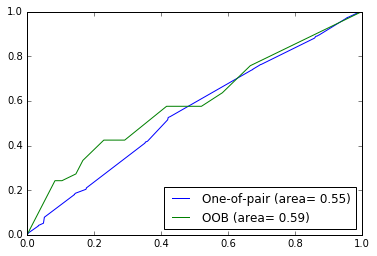

In [53]:
drugpair_predictions(X,y,X_test)

In [11]:
with open('/home/rvanguri/drugs_simple_chem_features_formatted.txt') as f:
    reader = csv.reader(f)
    
    druglist = list()
    chem_features = np.zeros((1,64))
        
    for line in reader:
        druglist.append(line[0])
        this_chem_features = np.zeros((1,64))
        #print line
        rxnorm = line[0]
        for i in range(1,len(line)-1):
            #print line[i]
            this_chem_features[0,i-1] = line[i]
        if reader.line_num==1:
            chem_features = this_chem_features
        else:
            chem_features = np.vstack((chem_features,this_chem_features))
            

In [14]:
print chem_features.shape
print len(druglist)

(3525, 64)
3525
